### Random Forest Regression

#### Load Data

In [3]:
import pandas as pd
import numpy as np

data = pd.read_parquet('../linear_model/data/harmonized_data.parquet')
pd.set_option('mode.chained_assignment',  None)

In [4]:
target_name = 'MISO ActualLoad (MWh)'
y = data[target_name]
feature_names = [col for col in data.columns if not col.endswith('(MWh)') and not col == 'Market Day']
X = data[feature_names]
X['Day of Year'] = data['Market Day'].dt.day_of_year
feature_names.append('Day of Year')

#### Features: Prior 36 Hours of Actual Load

Here we take the time series problem of predicting Hourly Load and make it into a supervised learning problem.

In [5]:
num_hours_prior = 36
def prior_load_colname(i : int):
    return f"Actual Load {i} hours prior"

for i in range(num_hours_prior, 0, -1):
    col_name = prior_load_colname(i)
    X[col_name] = y.shift(i)
    feature_names.append(col_name)

data = X[num_hours_prior:].join(y[num_hours_prior:])
data.head()

,AEX,ANJ,ARB,ARR,BMI,BTR,CID,CMI,COU,DET,...,Actual Load 9 hours prior,Actual Load 8 hours prior,Actual Load 7 hours prior,Actual Load 6 hours prior,Actual Load 5 hours prior,Actual Load 4 hours prior,Actual Load 3 hours prior,Actual Load 2 hours prior,Actual Load 1 hours prior,MISO ActualLoad (MWh)
2015-02-02 20:00:00+00:00,46.94,8.06,15.08,10.94,16.16,48.92,6.08,17.06,21.92,19.94,...,75223.18,81028.25,88440.97,91096.37,91098.40,90665.01,89534.20,87999.78,86359.75,83605.58
2015-02-02 21:00:00+00:00,48.02,8.96,15.08,10.04,16.16,51.08,6.98,17.96,21.92,19.94,...,81028.25,88440.97,91096.37,91098.40,90665.01,89534.20,87999.78,86359.75,83605.58,83249.35
2015-02-02 22:00:00+00:00,48.02,8.96,15.08,8.96,16.16,51.08,8.06,17.06,23.00,17.96,...,88440.97,91096.37,91098.40,90665.01,89534.20,87999.78,86359.75,83605.58,83249.35,84952.09
2015-02-02 23:00:00+00:00,46.04,10.04,10.94,8.06,14.00,50.00,6.98,15.08,21.92,15.98,...,91096.37,91098.40,90665.01,89534.20,87999.78,86359.75,83605.58,83249.35,84952.09,89921.21
2015-02-03 00:00:00+00:00,44.06,6.98,-0.04,8.06,13.10,46.04,6.98,12.92,19.94,14.00,...,91098.40,90665.01,89534.20,87999.78,86359.75,83605.58,83249.35,84952.09,89921.21,93178.78


### Train / Test Split

We will evaluate the performance of the model for the entire year of 2021

In [4]:
data_train = data[data.index < '2021-1-1']
data_test = data.drop(data_train.index)

### Model Evaluation

We evaluate our model performance against the MISO Medium-term Load Forecast (MTLF). The MTLF is provided 18 hours in advance.

We trained on actual weather observations, but the MTLF must use the best 18-hour weather forecast available.

Ideally we would compare our performance by using the same forecast used in the MTLF, but this information is not available.

We choose to add Gaussian noise to the weather observations in the test set to simulate the uncertainty in the weather forecast.

In [ ]:
mtlf = pd.read_parquet('../linear_model/data/actuals_mtlf.parquet')
mtlf_col = 'MISO MTLF (MWh)'
test_data_with_mtlf = data_test.join(mtlf[[mtlf_col,'time_idx']].set_index('time_idx'), how='inner')

weather_stations = data.columns[0:38]

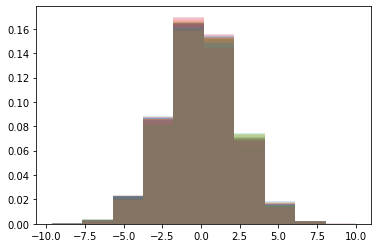

In [5]:
data_test_forecast_error = data_test.copy()

#from scipy.stats import skewnorm
#forecast_error = skewnorm.rvs(4, scale = 2.25, size=data_test[weather_stations].shape)
#forecast_error = forecast_error * np.random.choice([-1,1], forecast_error.shape, p=[0.5, 0.5])

forecast_error = np.random.normal(0, 2.25, data_test[weather_stations].shape)
data_test_forecast_error[weather_stations] = data_test[weather_stations] + forecast_error
data_test_forecast_error = data_test_forecast_error.drop(target_name, axis=1)


from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.hist(forecast_error, density=True, histtype='stepfilled', alpha=0.2)
plt.show()


#### MTLF Performance Baseline

In [6]:
from sklearn.metrics import mean_absolute_error, max_error

def show_error(y, yhat):
    MAE = mean_absolute_error(y, yhat)
    m = max_error(y, yhat)
    total = sum(abs(y - yhat))
    return f"Mean Absolute Error = {MAE}, Max Error = {m}, Total Error = {total}"
'MTLF ' + show_error(data_test[target_name], test_data_with_mtlf[mtlf_col])

'MTLF Mean Absolute Error = 1137.353402483565, Max Error = 10105.800000000003, Total Error = 7785184.040000005'

In [12]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(hyper_n = 500, hyper_sample_pct=0.5):
    model = RandomForestRegressor(n_estimators=hyper_n, max_samples=hyper_sample_pct, n_jobs=4)
    model.fit(data_train.drop(target_name, axis=1), data_train[target_name])
    return model

def mtlf_predict_window(model, X_test, forecasts = None):
    window_size = X_test.shape[0]
    assert(window_size > 0)
    forecast_index = window_size - 1
    if forecasts is None:
        forecasts = np.zeros(window_size)
    if computed_forecast := forecasts[forecast_index] > 0:
        return computed_forecast

    if window_size > 1:
        # predict the next window size hours, using the first prediction in the second,
        # the second in the third, and so on. Return only the last.
        for i in range(1, window_size):
            col_idx = X_test.columns.get_loc(prior_load_colname(i))
            X_test.iloc[-1, col_idx] = mtlf_predict_window(model, X_test[:-i], forecasts)

    forecasts[forecast_index] = model.predict(X_test.tail(1))
    return forecasts[forecast_index]

def mtlf_predict(model, X):
    n = X.shape[0]
    yhat = np.zeros(n)

    # "cheat" on first 17 hours
    yhat[0:16] = model.predict(X[0:16])

    mtlf_window_size = 18
    for start in range(0, n - mtlf_window_size + 2):
        stop  = mtlf_window_size + start - 1
        yhat[stop-1] = mtlf_predict_window(model, X[start:stop].copy())
    return yhat

In [13]:
model = train_random_forest()

In [14]:
contig_start = '2021-1-1 10:00'
contig_end = '2021-01-03 10:00'
contiguous_test = data_test[(data_test.index >= contig_start) & (data_test.index <= contig_end)]

In [15]:
yhat = mtlf_predict(model, contiguous_test.drop(target_name, axis=1))
f'Prediction error: {show_error(contiguous_test[target_name], yhat)}'

'Prediction error: Mean Absolute Error = 3616.7684929166367, Max Error = 11833.475179999827, Total Error = 173604.88765999855'

In [16]:
contig_mtlf = test_data_with_mtlf[(test_data_with_mtlf.index >= contig_start) & (test_data_with_mtlf.index <= contig_end)]
f'MTLF error same period: {show_error(contiguous_test[target_name], contig_mtlf[mtlf_col])}'

'MTLF error same period: Mean Absolute Error = 1441.0556250000009, Max Error = 3073.5099999999948, Total Error = 69170.67000000006'

In [17]:
model2 = train_random_forest(hyper_n=1000, hyper_sample_pct=1.0)
yhat2 = mtlf_predict(model2, contiguous_test.drop(target_name, axis=1))
f'Prediction error: {show_error(contiguous_test[target_name], yhat2)}'

'Prediction error: Mean Absolute Error = 3711.429818958293, Max Error = 13162.90067999957, Total Error = 178148.63130999805'